In [3]:
from enum import Enum
import math


import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

from funclib.iolib import folder_open
from funclib.baselib import pickle, unpickle
from funclib.numericslib import roundx
from dblib import mssql
from plotlib.mplfuncs import FigWidthsInch

In [3]:
#GET DATAFRAME FROM SQL

In [2]:
sql="select tl_mm, lens_subj_triangle_est, abs(rotation) as rotation ,accuracy ,hw_ratio, all_corr_rot_adj2_mm_error_perc as bias_percent, abs(all_corr_rot_adj2_mm_error_perc) as abs_bias_percent from v_mv_long_form where cnn = 'nas' and (transform like 'r%' or transform like 'none') and accuracy>0.5"

with mssql.Conn('imagedb', '(local)') as cnn:
    df_hwratio = pd.read_sql(sql, cnn)
list(df_hwratio)

['tl_mm',
 'lens_subj_triangle_est',
 'rotation',
 'accuracy',
 'hw_ratio',
 'bias_percent',
 'abs_bias_percent']

In [ ]:
#FORMAT THE DATA FOR SKLEARN CONSUMPTION, DO SOME SETUP

In [4]:
rotation = np.array(df_hwratio.rotation)
accuracy = np.array(df_hwratio.accuracy)
hw_ratio = np.array(df_hwratio.hw_ratio)
bias_percent = np.array(df_hwratio.bias_percent)
n_samples = rotation.shape[0]

#bias_percent vs hw_ratio
hw_bias = np.c_[hw_ratio, bias_percent]
hw_bias_acc = np.c_[hw_ratio, bias_percent, accuracy]

X = np.copy(hw_bias) #the data
print(X.shape)

hw_bias.shape: (16508, 2)   hw_bias_acc.shape: (16508, 3)


In [ ]:
#Split data into train and valuation

In [ ]:
train, valuation = train_test_split(hw_bias_acc)

In [33]:
#RANDOM FOREST ON HW_BIAS

In [35]:
outliers_fraction = 0.1

clf = IsolationForest(max_samples=n_samples, contamination=outliers_fraction, random_state=np.random.RandomState(28)) #the classifier
clf.fit(X)
scores_pred = clf.decision_function(X)
y_pred = clf.predict(X)

threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

levels=[threshold, Z.max()]
levels.sort()
print('Done')


Done


In [36]:
#PLOT IT

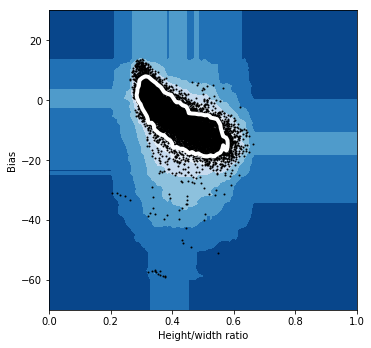

In [37]:
xlim = (0, 1); ylim = (-70, 30)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))

plt.figure(figsize=(W, H))
ax = plt.gca()

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)
#plt.contourf(xx, yy, Z, levels=[threshold, Z.max()].sort(), colors='orange')

b = plt.scatter(X[:,0], X[:,1], c='white', s=1, edgecolor='k')
a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=4, colors='white')


plt.axis('tight')
#plt.legend([a.collections[0], b, c], ['learned decision function', 'true inliers', 'true outliers'], prop=matplotlib.font_manager.FontProperties(size=10), loc='lower right')
ax.set_xlabel('Height/width ratio')
ax.set_ylabel('Bias')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/hw_outliers.svg', dpi=500)
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/hw_outliers.jpg')
folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images')

plt.show()